**数据预处理部分：**
- 数据增强： 对图像进行随机裁剪、随机翻转等操作，以增加数据集的多样性。
- 数据标准化： 将图像像素值缩放到0到1之间，以提高模型的收敛速度和稳定性。
- 数据划分： 将数据集划分为训练集、验证集和测试集，以便进行模型训练、验证和测试。

**使用torchvision中的transforms模块进行数据增强和标准化操作，使用torch.utils.data中的DataLoader模块进行数据划分和批量加载。**

**网络模块设置：**
- 加载预训练模型，torchvision中有很多经典的模型，如AlexNet，VGG，ResNet等，可以直接加载使用。直接用训练好的权重参数继续训练，即可达到迁移学习的效果。

- 需要修改最后的head层，一般为全连接层，根据自己的任务进行修改。


**网络模型保存与测试**

- 模型保存的时候可以带有选择性的保存，如只保存模型的参数，或者保存整个模型。
- 读取模型进行实际测试

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn  as nn  
import torch.optim  as optim
import torch.nn.functional  as F
from torchvision import datasets, transforms,models
import imageio
import time 
import random 
import sys

import warnings
warnings.filterwarnings('ignore')
from PIL import Image
%matplotlib inline

**数据读取与预处理操作**

In [2]:
data_dir=''
train_dir=data_dir+'/train'
valid_dir=data_dir+'/valid'

**制作好数据源**

- data_transform中指定了图像预处理的方法
- imagesfolder中指定了数据的路径

In [3]:
data_transforms={
    'train':
        transforms.Compose([
            transforms.Resize([96,96]),
            transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=15),# 随机旋转
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=64),  # Image net standards
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    ]),
    'valid':
        transforms.Compose([
            transforms.Resize([64,64]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
     
    ]),

}

In [5]:
batch_size=128
image_datasets = {}
for x in ['train', 'valid']:
    image_datasets[x] = datasets.ImageFolder(os.path.join(data_dir, x), 
                                             data_transforms[x])
image_datasets 

{'train': Dataset ImageFolder
     Number of datapoints: 4087
     Root location: train
     StandardTransform
 Transform: Compose(
                Resize(size=[96, 96], interpolation=bilinear, max_size=None, antialias=warn)
                RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
                RandomHorizontalFlip(p=0.5)
                CenterCrop(size=(64, 64))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 1021
     Root location: valid
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor

In [6]:
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True) for x in ['train', 'valid']}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1b118176e20>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x1b1181762e0>}

In [7]:
datasets_sizes={x: len(image_datasets[x]) for x in ['train','valid']}
class_names=image_datasets['train'].classes
datasets_sizes,class_names


({'train': 4087, 'valid': 1021}, ['Cracked', 'Non-cracked'])

### 加载models提供的模型，并直接使用训练好的权重做初始化参数

In [8]:
model_name ='resnet'# 还有其他的模型，例如vgg，resnet，densenet，mobilenet，squeezenet
feature_extract = True # 是否使用特征

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**模型参数需不需要更新**

In [10]:
model_ft=models.resnet18()
model_ft


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
def  set_parameter_requires_grad(model,feature_extract):
    if feature_extract:
        for param in  model.parameters():
            param.requires_grad = False

In [12]:
for name,param in model_ft.named_parameters():
    if param.requires_grad==True:
        print("\t",name)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

**把模型输出层修改为适合自己任务**

In [13]:
def  initialize_model(model_name,num_class,feature_extract,use_pretrained=True):

    model_ft = models.__dict__[model_name](pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extract)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_class)
    
    input_size = 64
    return  model_ft,input_size

**设置那些层需要训练**

In [19]:
file_name="restnet_best.pt"
params_to_update =model_ft.parameters()
print("params to learn ")
if feature_extract:
    params_to_update =[]
    for name,param in model_ft.named_parameters():
        if param.requires_grad==True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad==True:   
            print("\t",name)  

params to learn 
	 fc.weight
	 fc.bias


In [16]:
import os
os.environ["TORCH_HOME"]='./torch-model'
model_ft,input_size =initialize_model(model_name='resnet18',num_class=len(class_names),
                feature_extract=True,use_pretrained=True)

In [17]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**优化器设置**

In [20]:
optim_ft=optim.Adam(params_to_update,lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optim_ft, step_size=10, gamma=0.1)
loss_func=nn.CrossEntropyLoss()

In [ ]:
#  训练
import copy
def  train_model(model,dataloaders,loss_func,optim,file_name,num_epochs=25,):
    since=time.time()
    best_acc=0
    model.to(device)
    val_acc_history=[]
    train_acc_history=[]
    train_loss=[]
    valid_loss=[]
    # lr
    Lrs=[optim.param_groups[0]['lr']]
    best_model_wts=copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs+1):
        print(f"Epoch {epoch}/{num_epochs}")
        print("-"*10)
        
        # 训练和验证
        for phase  in  ['train','valid']:
            if phase =="train":
                model.train()
            else:
                model.eval()
            running_loss=0
            running_correct=0
            
            for  inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                optim.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(inputs)
                    loss=loss_func(outputs,labels)
                    _,preds=torch.max(outputs,1)
                    if phase=='train':
                        loss.backward()
                        optim.step()
                        
                running_loss+=loss.item()*inputs.size(0)
                running_correct+=torch.sum(preds==labels.data)
            epoch_loss=running_loss/len(dataloaders[phase].dataset)
            epoch_acc=running_correct.double()/len(dataloaders[phase].dataset)
            time_elapsed =time.time()-since
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            print(f'time_elapsed {time_elapsed//60}m, {time_elapsed%60}s')
            
            
            
            if phase =="valid" and epoch_acc > best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
                state={
                    'model':model.state_dict(),
                    'optim':optim.state_dict(),
                    'best_acc':best_acc,
                    }
                torch.save(state,file_name)
            if  phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_loss.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss.append(epoch_loss)
    
        print(f"optim learning rate: {optim.param_groups[0]['lr']}")
        Lrs.append(optim.param_groups[0]['lr'])
        print()
        scheduler.step()

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model,val_acc_history,train_acc_history,valid_loss,train_loss,Lrs        

In [26]:
model_ft,val_acc_history,train_acc_history,valid_loss,train_loss,Lrs=train_model(
                                            model_ft,dataloaders,
                                            loss_func=loss_func,optim=optim_ft,
                                            file_name="restnet_best.pt",num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5933 Acc: 0.6956
time_elapsed 0.0m, 14.029219150543213s
valid Loss: 0.6317 Acc: 0.6709
time_elapsed 0.0m, 16.314486265182495s
optim learning rate: 1e-05

Epoch 1/9
----------
train Loss: 0.5977 Acc: 0.6878
time_elapsed 0.0m, 29.96121311187744s
valid Loss: 0.6307 Acc: 0.6738
time_elapsed 0.0m, 31.92046308517456s
optim learning rate: 1e-05

Epoch 2/9
----------
train Loss: 0.5988 Acc: 0.6942
time_elapsed 0.0m, 44.99903893470764s
valid Loss: 0.6337 Acc: 0.6738
time_elapsed 0.0m, 46.86019968986511s
optim learning rate: 1e-05

Epoch 3/9
----------
train Loss: 0.5885 Acc: 0.6924
time_elapsed 0.0m, 58.885385274887085s
valid Loss: 0.6344 Acc: 0.6719
time_elapsed 1.0m, 0.4831387996673584s
optim learning rate: 1e-05

Epoch 4/9
----------
train Loss: 0.5861 Acc: 0.6927
time_elapsed 1.0m, 11.325142621994019s
valid Loss: 0.6345 Acc: 0.6690
time_elapsed 1.0m, 12.839263677597046s
optim learning rate: 1e-05

Epoch 5/9
----------
train Loss: 0.5834 Acc: 0.7052
time_el

In [27]:
for  param in model_ft.parameters(): 
    param.requires_grad = True

optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loss_func = nn.CrossEntropyLoss()

In [28]:
# 加载之前的权重参数
checkpoint =torch.load(file_name)
best_acc=checkpoint["best_acc"]
model_ft.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [29]:
model_ft,val_acc_history,train_acc_history,valid_loss,train_loss,Lrs=train_model(
    model_ft,dataloaders,
    loss_func=loss_func,optim=optim_ft
    ,file_name="restnet_best.pt",num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6024 Acc: 0.6924
time_elapsed 0.0m, 12.239003896713257s
valid Loss: 0.6322 Acc: 0.6768
time_elapsed 0.0m, 13.848424196243286s
optim learning rate: 1.0000000000000002e-06

Epoch 1/9
----------
train Loss: 0.5985 Acc: 0.6834
time_elapsed 0.0m, 25.970088005065918s
valid Loss: 0.6385 Acc: 0.6719
time_elapsed 0.0m, 27.47072720527649s
optim learning rate: 1.0000000000000002e-06

Epoch 2/9
----------
train Loss: 0.5975 Acc: 0.6897
time_elapsed 0.0m, 38.9867799282074s
valid Loss: 0.6350 Acc: 0.6729
time_elapsed 0.0m, 40.47974157333374s
optim learning rate: 1.0000000000000002e-06

Epoch 3/9
----------
train Loss: 0.5961 Acc: 0.6834
time_elapsed 0.0m, 52.153769969940186s
valid Loss: 0.6370 Acc: 0.6729
time_elapsed 0.0m, 53.651224851608276s
optim learning rate: 1.0000000000000002e-06

Epoch 4/9
----------
train Loss: 0.5971 Acc: 0.6890
time_elapsed 1.0m, 5.123283624649048s
valid Loss: 0.6415 Acc: 0.6670
time_elapsed 1.0m, 6.655757427215576s
optim learning rate: 

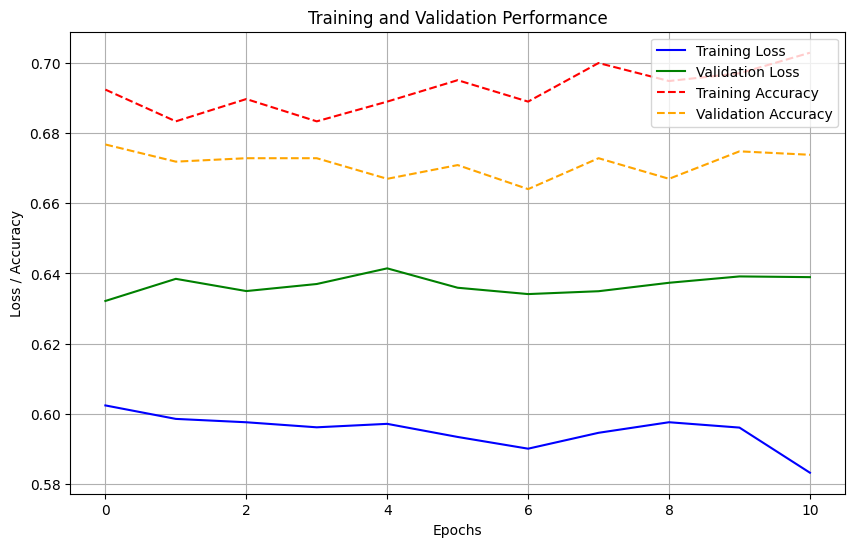

In [36]:
plt.figure(figsize=(10, 6))  # Set figure size

# Plot loss
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(valid_loss, label='Validation Loss', color='green')
train_acc_history = [t.cpu().numpy() for t in train_acc_history]
val_acc_history = [t.cpu().numpy() for t in val_acc_history]
# Plot accuracy on the same axes
plt.plot(train_acc_history, label='Training Accuracy', color='red', linestyle='--')
plt.plot(val_acc_history, label='Validation Accuracy', color='orange', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')  # Combined label for both y-axes
plt.title('Training and Validation Performance')
plt.legend()
plt.grid(True)  # Add grid lines

plt.show()

###  加载训练好的模型


In [38]:
model_ft,input_size=initialize_model(model_name="resnet18",num_class=len(class_names),feature_extract=True,use_pretrained=True)

model_ft.to(device)
checkpoint =torch.load(file_name)
best_acc=checkpoint["best_acc"]
model_ft.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [39]:
dataloader=iter(dataloaders['valid'])
images,labels=next(dataloader)

model_ft.eval()
outputs=model_ft(images.to(device))

In [90]:
_,preds_tensor=torch.max(outputs,dim=1)

if torch.cuda.is_available():
    preds = np.squeeze(preds_tensor.detach().cpu().numpy())
else:
    preds = np.squeeze(preds_tensor.detach().numpy())
    
labels,preds

(tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
         0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
         1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
         0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
         0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
         1, 0, 1, 1, 0, 1, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64))

In [ ]:
def im_convert(tensor):
    image =tensor.to('cpu').clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image=image.clip(0,1)
    return image

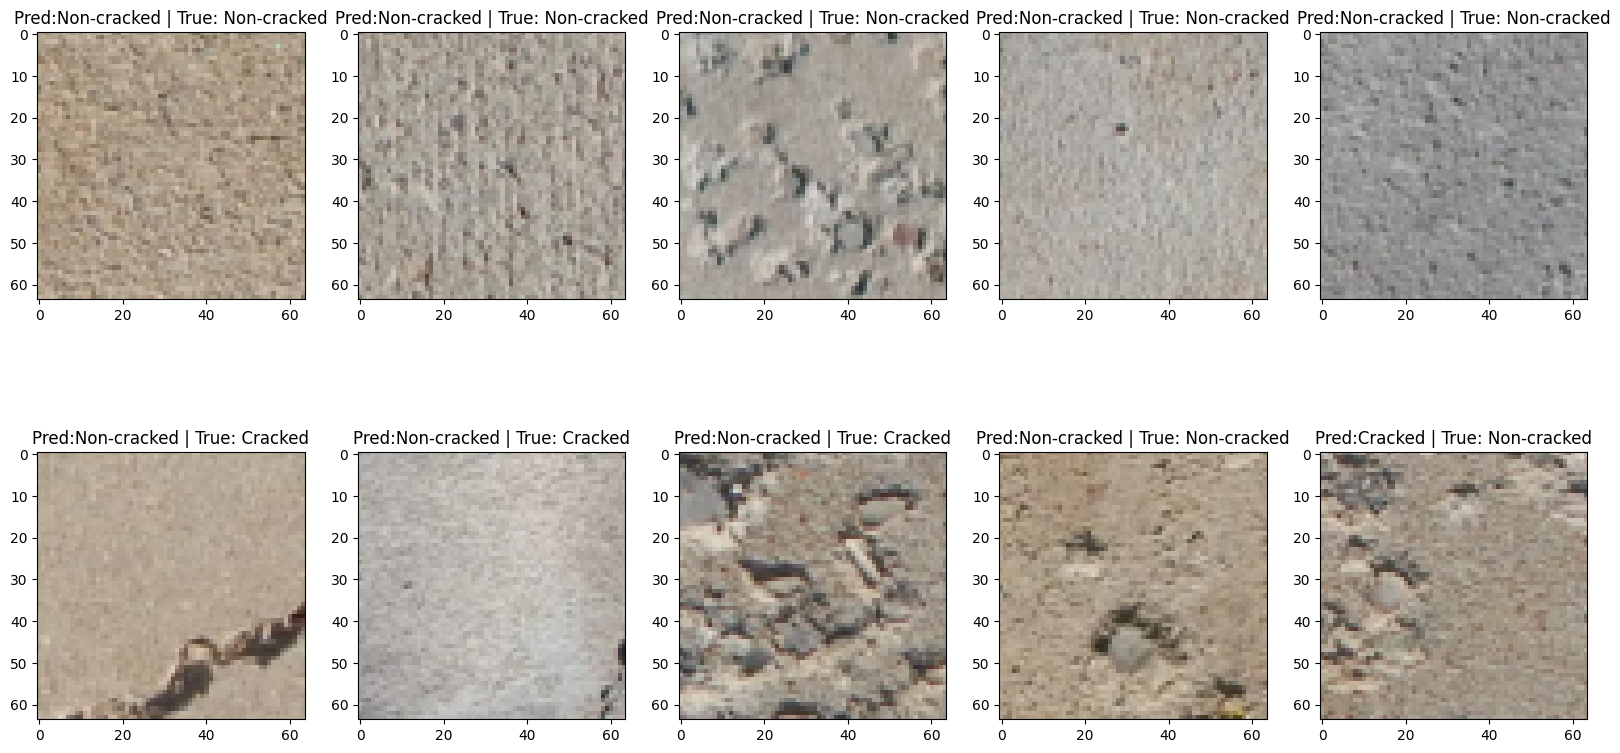

In [88]:
fig = plt.figure(figsize=(20, 10))
columns = 5
rows =2
for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx+1 )
    plt.imshow(im_convert(images[idx+1]), interpolation='nearest')
    ax.set_title(f'Pred:{class_names[preds[idx]]} | True: {class_names[labels[idx]]}')
    
plt.show()
